In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Comparación de modelos

 > "Todos los modelos están equivocados, pero algunos son útiles" George Box.

La creación de modelos es un proceso iterativo, ya sea que estemos hablando del desarrollo de teorías científicas a lo largo de décadas y con la participación de cientos o miles de personas o _modelos mínimos_ como los que realizamos cotidianamente como estimar la media de una distribución. Como vimos anteriormente este proceso iterativo se suele describir con tres pasos.

1. Crear un modelo
2. Condicionar el modelo a los datos observados 
3. Evaluar el ajuste del modelo generado a los datos y evaluar las implicancias del modelo.

Las conclusiones del paso 3 nos llevarán, posiblemente, a volver sobre los pasos 1 y 2. A veces será necesario modificar el modelo, en general expandiéndolo. Esto nos conduce a tener que comparar entre más de un modelo que explica un mismo conjunto de datos. 

Al comparar y evaluar modelos hay que tener en cuenta que, en general, lo que determinamos es la bondad relativa de los modelos. Podríamos determinar que el modelo $A$ es mejor que el modelo $B$, pero eso no implica que $A$ sea realmente un buen modelo

A fin de ilustar la problemática y metodologías involucradas en comparar modelos vamos a empezar generando dos modelos sencillos. Los datos que usaremos se corresponden con el primer conjunto del cuarteto de Anscombe. Vamos a probar hacer un ajuste lineal y uno cuadrático por el otro, estos serán nuestro dos modelos.

In [2]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

Las siguientes lineas sirven para crear un arreglo a partir de $x_1$ cuyas dimensiones dependan del orden del polinomio a usar.

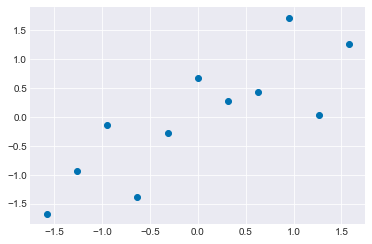

In [3]:
orden = 2
x_1p = np.vstack([x_1**i for i in range(1, orden+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s);

Ahora hacemos un regresión lineal simple.

In [4]:
with pm.Model() as modelo_l:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 10)

    μ = α + β * x_1s[0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:02<00:00, 527.46it/s]


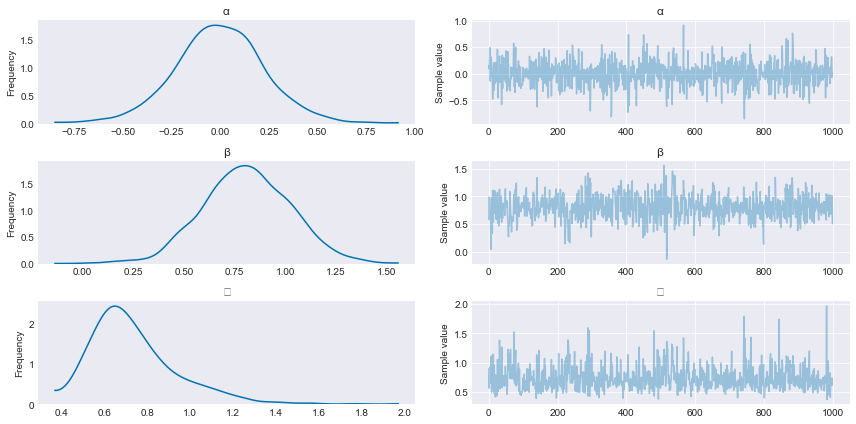

In [5]:
pm.traceplot(trace_l);

El segundo modelo es una extensión del primero en donde hemos agregado un término cuadrático. En la linea 6 se puede ver que hemos descripto $\mu$ como $\alpha + \beta \cdot x_1s$. El producto punto es simplemente una forma abreviada de escribir la suma de los productos entre el vector de parámetros $\beta$ y el vector de datos $x\_1s$.

In [6]:
with pm.Model() as modelo_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=len(x_1s))
    ϵ = pm.HalfNormal('ϵ', 10)
    
    μ = α + pm.math.dot(β, x_1s)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:09<00:00, 158.16it/s]


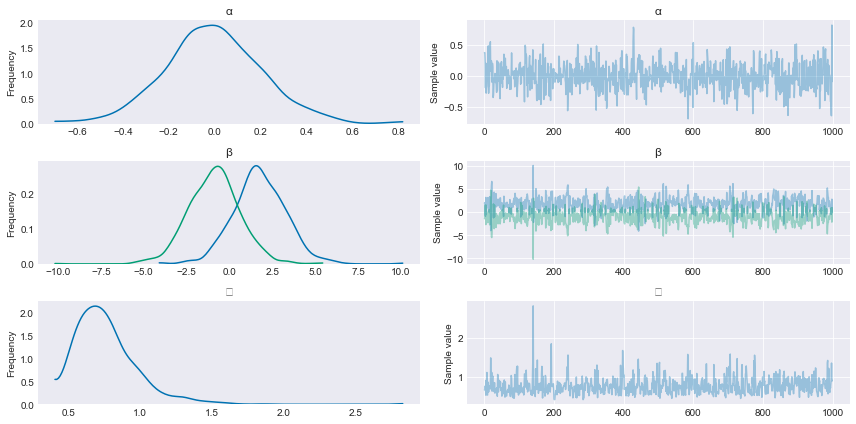

In [7]:
pm.traceplot(trace_p);

In [8]:
pm.df_summary(trace_p).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
α,-0.01,0.21,0.01,-0.42,0.41
β__0,1.73,1.52,0.06,-1.18,4.55
β__1,-0.94,1.51,0.06,-3.63,2.11
ϵ,0.77,0.22,0.01,0.44,1.19


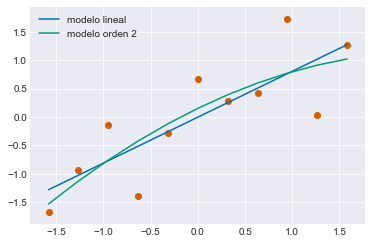

In [9]:
x_nuevo = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_nuevo

plt.plot(x_nuevo, y_l_post, label='modelo lineal')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='modelo orden {}'.format(orden))

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_nuevo_p = np.vstack([x_nuevo**i for i in range(1, orden+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_nuevo_p) 

#plt.plot(x_nuevo_p[0], y_p_post, label='Bayes pol orden {} outrange'.format(orden))


plt.scatter(x_1s[0], y_1s, c='C2')
plt.legend();

## Pruebas predictivas _a posteriori_

Como ya vimos una forma de evaluar modelos es mediante pruebas predictivas _a posteriori_, es decir evaluar en que grado el modelo es capaz de generar datos que se asemejen a los datos usados para generar el modelo. Recordemos que el principal objetivo de las pruebas predictivas _a posteriori_ no es establecer un criterio dicotómico mal-bien, correcto-incorrecto, si no tratar de determinar en que medida el modelo es capaz de capturar los datos y en que medida no.

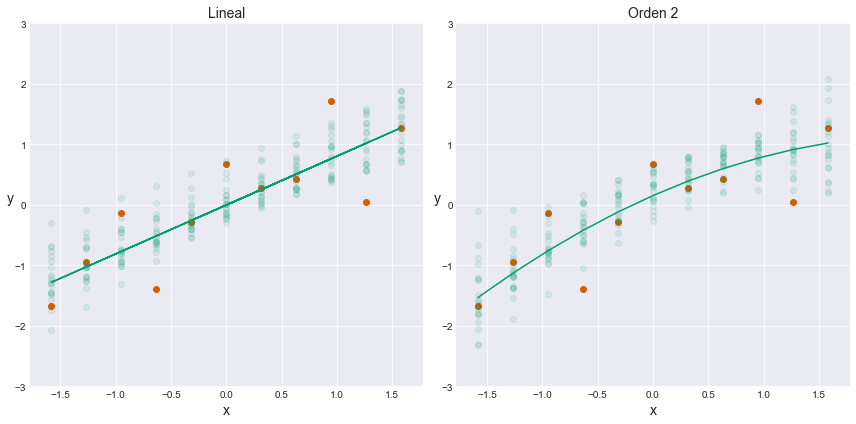

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='C2');
plt.ylim(-3, 3)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14, rotation=0)
plt.title('Lineal', fontsize=14)
for i in range(0, len(trace_l['α']), 50):
    plt.scatter(x_1s[0], trace_l['α'][i] + trace_l['β'][i]*x_1s[0],
                c='C1', alpha=0.1);
plt.plot(x_1s[0], trace_l['α'].mean() + trace_l['β'].mean()*x_1s[0], c='C1')

    
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='C2');
plt.ylim(-3, 3)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14, rotation=0)
plt.title('Orden {}'.format(orden), fontsize=14)
for i in range(0, len(trace_p['α']), 50):
    plt.scatter(x_1s[0], trace_p['α'][i] + np.dot(trace_p['β'][i], x_1s),
                c='C1', alpha=0.1)
ordenado = np.argsort(x_1)
plt.plot(x_1s[0][ordenado], α_p_post + np.dot(β_p_post, x_1s)[ordenado], c='C1');


plt.tight_layout();

## La navaja de Occam, simplicidad vs exactitud

Intuitivamente, un factor que generalmente debemos tener en cuenta al comparar modelos es cuán bien el modelo ajusta los datos, esto es lo que hicimos en la sección anterior de forma visual mediante las pruebas predictivas _a posteriori_. Pero supongamos que tenemos dos modelos para los mismos datos y ambos parecen explicar los datos igualmente bien. ¿Qué modelo debemos elegir? 

Hay un principio metodológico conocido como la navaja de Occam el cual afirma:

 > En igualdad de condiciones, la explicación más sencilla suele ser la más probable.

Es decir si tenemos dos o más explicaciones equivalentes para el mismo fenómeno, deberíamos elegir la más simple. Es importante notar que este principio es tan solo una guía y no algo que necesariamente sea siempre cierto. De todas formas hay muchas justificaciones para esta heurística; una de ellos está relacionado con el criterio de falsabilidad introducido por Popper, otra toma una perspectiva pragmática, ya que los modelos más simples son más fáciles de entender que los modelos más complejos, y otra justificación se basa en las estadística Bayesiana! Sin entrar en los detalles de estas justificaciones, vamos a aceptar este criterio como una regla generalmente útil.

Bien, espero que estén de acuerdo con que al comparar modelos nos interesa considerar exactitud y _simplicidad_.

Exploremos estas nociones usando un ejemplo clásico, polinomios.

## Demasiados parámetros conducen a un sobre-ajuste

En la siguiente figura, podemos ver que el aumento de la complejidad del modelo (según el grado del polinomio) es acompañado de un ajuste cada vez mayor (según la desviación cuadrática media, rmsd por su sigla en inglés). Incluso, es posible ver que el polinomio de orden 5 ajusta los datos de forma perfecta!

<img src="imagenes/rightfitting_00.png" width=550>


¿Por qué el polinomio de grado 5 es capaz de capturar los datos sin perder ni siquiera un solo dato? La razón es que tenemos el mismo número de parámetros, 6, que de datos. Por lo tanto el modelo es sólo una codificación diferente de los datos. El modelo no está realmente aprendiendo un patrón en los datos, simplemente está _memorizándolos_. Un problema al usar los mismos datos para ajustar un modelo que para evaluarlo, es que estaremos sobre-estimando la capacidad del modelo de explicar los datos. Es por esto que en general se prefiere evaluar un modelo usando datos no usados para ajustar el modelo.

En la siguiente figura se muestran dos puntos (cuadrádos) no usados para ajustar los polinomios, pero que pertenecen a la misma distribución (o _dataset_) que los que si se usaron

<img src="imagenes/rightfitting_01.png" width=550>

Al agregar estos nuevos puntos se hace claro que el polinomio de grado 5 muestra no solo un comportamiento extraño de los datos, si no uno que no es compatible con todos los puntos. En cambio, de forma intuitiva, los modelos de grado 1 o 2 parecen ser dar una explicación más parsimoniosa y una que parece no explicar ningún punto de forma exacta pero si el conjunto de puntos de forma aproximada. En general un modelo con _muchos_ parámetros tenderá a sobre-ajustar los datos.

## Pocos parámetros conducen a un sub-ajuste

Siguiendo con el mismo ejemplo, pero en el otro extremo de complejidad, tenemos un modelo de orden 0. En este modelo todo los parámetros $\beta$ valen 0, por lo tanto el modelo lineal, que relaciona dos variables, se ha reducido a una descripción de la variable dependiente como una Gaussiana. Para el modelo de orden 0 el valor de la variable independiente es irrelevante, lo único que el modelo es capaz de ver es la media de la variable dependiente. Este modelo ha sub-ajustado los datos, es tan simple que no es capaz de capturar ninguna relación entre ambas variables. En general un modelo con _pocos_ parámetros tenderá a sub-ajustar los datos.

## El balance entre simplicidad y exactitud

_Las cosas deben ser lo más simples posibles, pero no más simples_ es una cita que usualmente se le atribuye a Albert Einstein y es otra forma de navaja de Occam. Idealmente deberíamos lograr modelos que ni sobre-ajusten ni sub-ajusten los datos. Por lo tanto nos enfrentamos a una situación de compromiso, de alguna forma deberemos ser capaces de seleccionar el modelo más adecuado.

Una forma útil de pensar los modelos es como dispositivos de compresión de datos. De esta forma el propósito de ajustar (o aprender) un modelo es el de obtener una representación reducida de los datos, queremos simplificar los datos para entenderlos o poder predecir futuros datos. Si el modelo representa los datos de forma _demasiado_ comprimida perderemos detalles importantes y terminamos obteniendo resúmenes muy simples como una media, en el extremo opuesto obtenemos mucho ruido o incluso una representación igualmente compleja de los datos.


Una forma alternativa (y totalmente equivalente) de ver este balance entre sobre y sub-ajuste es discutirlo en términos del compromiso entre sesgo y varianza (_the bias-variance trade-off_). Sigamos con el ejemplo del modelo de orden 5, supongamos que ahora usamos un nuevo conjunto de 6 puntos para ajustar el modelo y luego otros 6 puntos y así sucesivamente una gran cantidad de veces. Cada vez que hagamos esto obtendremos una nueva curva que ajuste de forma exacta los 6 puntos. En un caso podríamos obtener una curva muy _ondulada_, en otro caso una linea recta, en otra una entre medio, etc. Debido a que el modelo se puede adaptar a cada punto/detalle de cada uno de los grupos de datos, nuestras predicciones tendrán mucha variabilidad, y diremos que el modelo tiene _alta varianza_ (high variance). Si en cambio nuestro modelo es una linea recta el modelo tendrá un mayor _sesgo_ (bias), en el sentido que sin importar la forma de los datos siempre ajustaremos una linea recta. Si se me permite la licencia para antropomorfizar, un modelo con gran sesgo es un modelo con más prejuicios o con mayor inercia.

El modelo de orden 1, en nuestro ejemplo, tiene mayor sesgo y menor varianza que el modelo de orden 2. El segundo puede producir curvas mayor variedad de curvas, incluso una linea recta, como caso particular. Resumiendo:

* Alto sesgo es el resultado de un modelo con baja capacidad para acomodarse a los datos. Alto sesgo puede causar que un modelo no capture patrones relevantes y por lo tanto conducir a sub-ajuste.
* Alta varianza es el resultado de un modelo con alta sensibilidad a los detalles en los datos. Alta varianza puede hacer que un modelo capture el ruido en los datos y por lo tanto conducir a sobre-ajuste.

En general al aumentar una de estas cantidades se disminuye la otra y por eso se suele hablar del compromiso varianza-sesgo. Una vez más concluimos que necesitamos balancear dos cantidades.

In [12]:
## Regularizing priors

In [13]:
## Regularizing priors and hierarchical models

In [14]:
## Predictive accuracy measures

## Criterios de Información

Formalmente si quisieramos evaluar un modelo necesitariamos crear una medida de _exactitud predictiva_. Es decir una métrica que estime con que exactitud (o onversamente con que grado de error) el modelo es capaz de predicir datos aún no observados. Intuitivamente, esto se logra midiendo cuanto se desvía el modelo de los datos. Mientrás mejor sea el error entre datos y modelo, mejor el modelo. Pero el criterio no puede ser tan simple, ya que en principio siempre es posible obtener un mejor modelo aumentado el número de parámetros hasta que logremos que el modelo explique los datos con error cero. El modelo habrá _aprendido_ no solo la señal en los datos si no el ruido en los datos! por lo que nuestro modelo servirá solo para explicar el conjunto de datos que usamos para determinar los parámetros pero será muy malo para explicar cualquier otro conjunto de datos, es decir habremos disminuido la _exactitud predictiva_ en vez de aumentarla. Este fenómemo se llama sobreajuste (overfitting). Lo que necesitamos es un criterio que penalice de alguna forma a modelos con mayor número de parámetros. 

Los modelos Bayesianos incluyen basicamente dos términos el _likelihood_ y el _a priori_ si aumentamos el número de paráemtros el likehood se torna más flexible y lograr _acomodar_ mejor un conjunto de datos, pero al mismo tiempo cada parámetro debe tener un _a priori_ mientrás más parámetros tenga el modelo más _extendido_ será el _a priori_, es decir menos probable _a priori_ esa combinación de parámetros. Esta es la razón por la cual en muchos problemas se puede ver al _a priori_ como un término que regulariza las predicciones de forma de disminuir las chances de _overfitting_ o en general de predicciones que no tienen demasiado sentido. Esto no quiere decir que un modelo Bayesiano sea inmune a estos problemas, solo que en general son menos sensibles a estos problemas. 


La mejor forma posible (y la menos útil de todas) es estimar la _exactitud predictiva_ evaluando que tan bueno es un modelo para explicar datos no usados para generar el modelo, el problema es que esto requiere de tener muchos datos disponibles como para _darse el lujo_ de dejar información de lado. En general nunca se tiene _demasiados_ datos, por que mientras más datos tenemos más preguntas queremos contestar con esos datos, y eso implica en general subdividir los datos en sub-grupos. La segunda mejor estrategia se conoce como validación cruzada (_cross-validation_), no entraremos en demasiado detalle pero basicamente consiste en separar el conjunto de datos en $K$ grupos y usar $K-1$ grupos para ajustar el modelo y el restante para evaluarlo. Este proceso se repite varias veces (siempre dejando un grupo distinto de lado y ajustando con el resto), de esta forma se obtiene una buena estimación de la _exactitud predictiva_ del modelo. 


Idealmente las medidas de exactitud predictiva deberían estar diseñadas _ad-hoc_ para cada problema. De esta forma podríamos intentar medir de forma lo más correcta posible la relación costo-beneficio de los errores o falta de exactitud de un modelo. No deberíamos medir con el mismo rigor el riesgo de un modelo erróneo cuando estimamos la contaminación de agua consumida por humanos, que el riesgo de un modelo que estima cuanto dinero debe gastar una empresa en publicidad en radio vs televisión. El uso de funciones de costo en la toma de decisiones usando modelos Bayesianos (o de otro tipo) pertenece a un campo de estudio llamado _análisis de decisiones_, del cual no diremos más nada en el resto el curso. 

Una medida que probablemente conozcan para estimar la bondad de un modelo es el error cuadrático medio.

$$\frac{1}{n} \sum_{i=1}^{n} (y_i - E(y_i|\theta))^2$$

Es decir el error promedio, respecto de la media elevado al cuadrado. Esta medida es muy usada por su simplicidad de cáculo y de interpretación pero tiene el problema que se vuelve cada vez menos adecuada a medida que los modelos se alejan más y más de la distribución normal.

El logaritmo natural del _likelihood_ $\log (p|\theta)$ es otra medida muy usada y es proporcional al error cuadrático medio si el modelo es Gaussiano con varianza constante. En el límite de muestras de gran tamaño (cuando el _a priori_ se vuelve irrelevante) el modelo con el _log-likehood_ más grande es también el modelo con el _a posteriori_ más grande.

Por razones históricas, y con fundamentación teórica en lo que se conoce como teoría de la información. Las medidas de exactitud predictiva basadas en el _log-likelihood_ se llaman genéricamente _criterios de información_. En general se basan en medir una cantidad conocida como desviación (_deviance_):

$$\log p(y|\hat{\theta})$$

Es decir el logaritmo del _likelihood_, dado una estimación puntual de $\theta$.

La idea general detrás de todos estos criterios es que existe un trade-off entre la bondad de ajuste (que tan bien el modelo explica los datos) y la complejidad del modelo (algo asi como el número de parámetros). Dentro de los criterios de información el AIC (Akaike Information Criteria), es una medida muy usada y se define como:

$$AIC = -2 \log p(y|\hat{\theta_{mle}}) + 2k $$

Entre dos modelos se prefiere aquel con menor AIC. El primer termino es el likelihood para un valor fijo de $\theta$ (el valor máximo del likelihood, maximun likelihood estimation _mle_), al ajustar modelos es posible aumentar el valor del _likelihood_ simplemente agregando parámetros esto le da flexibilidad al modelo para ajustarse a los datos (recordemos el ejemplo de la regresión lineal a la que agregamos un término cuadrático), el problema que esto podría conducir al sobreajuste (_overfitting_). Por eso, se introduce un término que penaliza la _complejidad_ del modelo, en este caso la cantidad de parámetros a estimar $k$.

AIC es una medida útil para modelos frecuentistas, pero no sirve para modelos Bayesianos por un lado no hace uso del _a posteriori_, por el otro en modelos con estructura jerárquica o que tengan _a prioris_ informativos, el número de parámetros efectivos no es $k$ si no que debe ser estimado a partir de los datos.

Otra medida es el BIC (_Bayesian Information Criteria_), aunque no es muy Bayesiano en realidad por lo que no lo discutiremos. Una medida usada en contexto Bayesianos es el DIC (_Deviance Information Criteria_). Que en vez de usar $\log p(y|\hat{\theta_{mle}})$ usa $\log p(y|\hat{\theta_{bayes}})$, es decir usa la media del _a posteriori_ de $\theta$ y vez de $k$ usa un término que estima el número efectivo de parametros a partir de los datos.

### WAIC

Por último tenemos a WAIC (aunque en la literatura hay muchos más). WAIC se podría considerar como el sucesor de DIC, ya que es similar en ciertos aspectos pero ha demostrado ser una mejor medida. A continuación se muestra como calcularlo a partir de $S$ simulaciones de un _a posteriori_, como las obtenidas usando PyMC3, $n$ es la cantidad de datos usados para ajustar el modelo:

$$WAIC = -2 lpd + 2 p_{WAIC}$$

$$lpd = \sum_{i=1}^{n} \log \left(\frac{1}{s}  \sum_{i=1}^{s}p(y_i|\theta^s)\right)$$

$$p_{WAIC} = \sum_{i=1}^{n} v_{s=1}^S (\log p(y_i|\theta^s))$$

El primer término, lpd, se calcula de la siguiente forma para cada dato se calcula la media del _likelihood_ a lo largo de los $S$ _pasos_ de la simulación luego a esas medias se les calcula el logaritmo y por último se suma sobre los $n$ datos. Para el término $p_{WAIC}$ el cálculo es parecido solo que en vez de calcular las medias de los _likelihoods_ se calcula la varianza de los _log-likelihood_. Como en los otros criterios de información el primer término tiene relación con el buen ajuste del los datos por parte del modelo (aumenta a medida que el ajuste mejora) y el segundo estima el número de parámetros efectivos (aumenta a medida que la _complejidad_ del modelo aumenta).

In [15]:
pm.waic(trace_l, modelo_l), pm.waic(trace_p, modelo_p)

/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


(WAIC_r(WAIC=25.670616549562585, WAIC_se=3.2686969255306413, p_WAIC=2.1810403927258322),
 WAIC_r(WAIC=26.314623117413262, WAIC_se=2.7199609794743398, p_WAIC=2.2844889194444216))

## Factores de Bayes

Una alternativa, muy usado para evaluar modelos, y quizá una de las que levanta mayores discusiones en los círculos Bayesianos el es uso de los llamados factores de Bayes. Los detractores del uso de los factores de Bayes argumentan que los factores de Bayes pueden ser muy sensibles a la elección de _a priori_, especialmente cuando se usan _a prioris_ poco informativos. No sensibles en el sentido que influyen en la estimación de parámetros (como hemos visto y que no es un problema) si no sensibles al punto de hacer inestables o poco confiables el resultado de los factores de Bayes. Además, el computo de los factores de Bayes para un modelo es más dificil y costoso que la estimación de los parámetros para ese modelo, en general el costo es un orden de magnitud superior. Otra crítica a los factores de Bayes es que pueden ser usados para hacer pruebas de hipótesis similares a las realizadas con métodos frecuentistas, el problema en estos casos es que estas pruebas de hipótesis sufren de muchos de los mismos que las pruebas hechas por medios frecuentistas (sol oque disfrazadas de Bayesianas), sumado al problema que ya dijimos sobre el computo costoso y la _inestabildiad_ propia de los factores de Bayes. Habiendo hecho todas estas aclaraciones (y teniendo en cuenta otras como  [esta](http://doingbayesiandataanalysis.blogspot.co.at/2015/12/lessons-from-bayesian-disease-diagnosis.html) o [esta otra](http://www.stat.columbia.edu/%7Egelman/research/published/avoiding.pdf)) pasemos a ver que son y como se calculan los factore de Bayes.

En general el teorema de Bayes se escribe como:

$$
p(\theta|y) = {\frac {p(y|\theta)p(\theta)}{p(y)}}
$$

donde $y$ son los datos y $\theta$ los parámetros o en general las hipótesis. Alternativamente podríamos escribirlo de la siguiente forma:


$$p(\theta|y, M) = {\frac {p(y|\theta, M)p(\theta|M)}{p(y|M)}}$$

La única diferencia entre la primer y segunda forma es que en la segunda se hace explícita la dependencia de la inferencia de un modelo $M$. El término del denominador, es llamado _evidencia_, hasta ahora lo habíamos obviado, ya que no es necesario determinar directamente al usar métodos de meustreo como Markov Chain Monte Carlo (MCMC). Y se corresponde con la siguiente expresión:

$$p(y|M) = \int p(y|\theta, M) p(\theta|M) d\theta_m$$

Es decir para calcular la _evidencia_ $p(y|M)$ hay que marginalizar (integrar o sumar según corresponda) sobre todos los valores posibles de $p(\theta|M)$, es decir sobre todos los valores posible de $\theta$ _a priori_ para un modelo dado. El por ello que tambien se la suele llamar _likelihood marginal_.

La cantidad $p(y|M)$ en si misma no nos dice demasiado, por ello lo que se suele hacer cuando se quiere comparar dos modelos es tomar el cociente de la evidencia para cada modelo y esto es lo que se conoce como factor de Bayes.

$$F_b = \frac{p(y|M_0)}{p(y|M_1)}$$

Si $F_b > 1$ entonces el modelo 0 explica los datos mejor que el modelo 1.

Algunos autores (como [Jeffreys](https://books.google.com/books?id=vh9Act9rtzQC&printsec=frontcover#v=onepage&q&f=false) y [Kass y Raftery](http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476572)) han propuesta tablas con rangos para interpretar los factores de Bayes del estilo de: 

* 1-5 "apenas vale la pena mencionar"
* 5-10 "importante/sustancial"
* 10-15 "fuerte"
* 15-20 "muy fuerte"
* $>$ 20 "decisivo"

o puntos de corte como si $F_b > 3$ el modelo 0 es _sustancialmente_ mejor que el 1, o de forma equivalente si $F_b < \frac{1}{3}$ el modelo 1 es _sustancialmente_ mejor que el 0. Estos criterios no son _reglas automáticas_ son guías que pueden llegar a ser útiles, pero la mejor aproximación es siempre poner los resultados numéricos en el contexto del problema, reportando la mayor cantidad de detalles posibles de forma que terceros puedan sacar sus propias conclusiones. 

El computo de los factores de Bayes y la comparación entre modelos se puede pensar como un modelo Bayesiano jerárquico en el cual el parámetro de interés a determinar y el que está más arriba en la jerarquía es un índice asociado a cada modelo que se compara. Es decir, haremos inferencia sobre los dos modelos en paralelo y podremos una variable discreta que visitará de forma alternada uno u otro modelo. La cantidad de veces que esta variable visita un modelo es proporcional a la probabilidad de ese modelo $p(M_x|y)$, para calcular el factor de Bayes deberemos hacer lo siguiente:

$$\frac{p(y|M_0)}{p(y|M_1)} = \frac{p(M_0|y)}{p(M_1|y)}  \frac{p(M_1)}{p(M_0)}$$

El primer término a la derecha de la igualdad es el _posterior odds_ y el segundo es el _a priori_ (_priors odds_). Esta ecuación es tan solo una consecuencia de escribir el teorema de Bayes para el cociente entre p(y|M_0) y p(y|M_1).

## Para seguir leyendo

* Capítulo 6 de Statistical Rethinking. Richard McElreath (1 [edición](https://www.amazon.com/dp/1482253445))
* Capítulos 6 y 7 de [Bayesian Data Analysis](https://www.amazon.com/dp/1439840954) de Andrew Gelman

* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)